# 16. Predicting Personality Index (Frame selection)

In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import r2_score

## Description

We predict personality index from gradients

GOAL: Predicting personality index from gradients

## Table of Contents

- [On Static Gradients](#staticgrad)



In [3]:
# Loading behavioural scores
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])

regions      = list(index2region.keys())
print(regions)

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Sub']


<a class="anchor" id="staticgrad"></a>
## On Static Gradients

#### Visual difference

In [4]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
nb_comp    = 3
rs         = 99

D = lambda x,y: ((x-y)**2).sum(axis=1)

In [5]:
total_series = load('./data/fmri_414_series.pkl')
f_series = load('./resources/treshed_series.pkl')

if 'Rest' in f_series: del f_series['Rest']
if 'Rest' in total_series: del total_series['Rest']

In [6]:
all_gradients = {k:{} for k in total_series}

for mname in total_series:
    tmp_dict = total_series[mname]
    for _id in tmp_dict:
        tmp_series = tmp_dict[_id]
        fc_selects = FC(tmp_series)
        g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
        g_selects.fit(fc_selects)
        grad = g_selects.gradients_
        # compute scores and store instead of using direct grad location
        
        fscore = D(grad.mean(axis=0), grad)
        all_gradients[mname][_id] = fscore

In [9]:
subject_grad = all_gradients['Sintel']
subjects     = list(subject_grad.keys())
regions      = list(index2region.keys())

feat     = existing_psy[6]
psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]

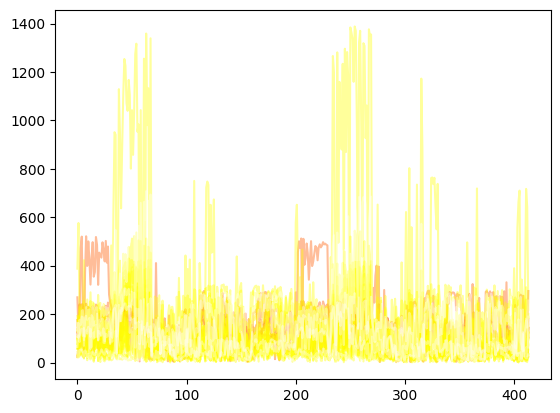

In [10]:
# for Display
order = np.argsort(psyscore)
ordered_grads = [subject_grad[subj] for subj in subjects]
G, coloring = [],[]

colors = plt.cm.hot(np.linspace(0,1,int(max(psyscore))+1))
for i in order:
    plt.plot(np.arange(414), ordered_grads[i], color=colors[int(psyscore[i])], alpha=0.4)

### Regress / Predictive

#### Model Visualization

In [171]:
# order_fixed = np.arange(30)
# np.random.shuffle(order_fixed)

Movie based prediction

In [172]:
X = [subject_grad[subj] for subj in subjects]
y = deepcopy(psy_yj)
train_X,val_X = X[:15],X[15:]
train_y,val_y = y[:15],y[15:]

(array([1., 0., 1., 1., 1., 3., 2., 3., 1., 2.]),
 array([-2.4633882 , -2.05091173, -1.63843526, -1.22595879, -0.81348232,
        -0.40100585,  0.01147062,  0.42394708,  0.83642355,  1.24890002,
         1.66137649]),
 <BarContainer object of 10 artists>)

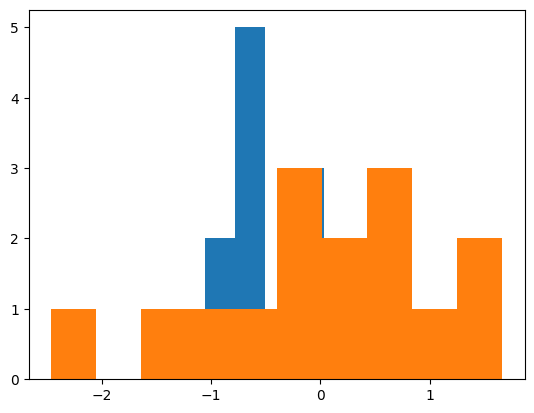

In [173]:
plt.hist(train_y)
plt.hist(val_y)

4
SpearmanrResult(correlation=-0.14775374388207166, pvalue=0.5992340835344223)
[0.0661974631698394]
451.3208289227228


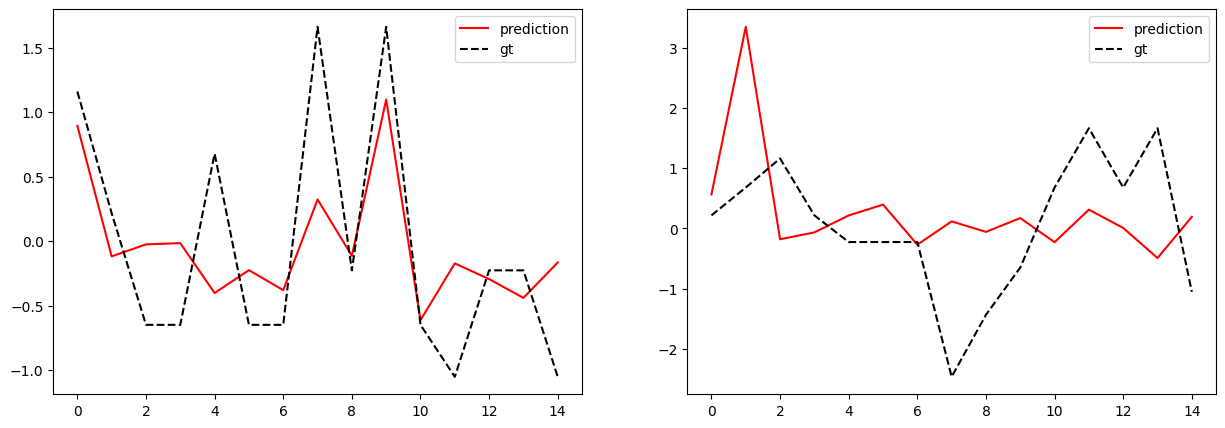

In [175]:
clf = Lasso(alpha=20)
clf.fit(train_X, train_y)
print(np.sum(clf.coef_!= 0))

pred = clf.predict(train_X).flatten()
pred_y = clf.predict(val_X).flatten()

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(pred, color='r', label='prediction')
ax[0].plot(train_y, color='k', linestyle='--', label='gt')
# print(pearson_correlation(arr1=np.array(pred_y), arr2=np.array(val_y)))
ax[0].legend()

ax[1].plot(pred_y, color='r', label='prediction')
ax[1].plot(val_y, color='k', linestyle='--', label='gt')
print(stats.spearmanr(np.array(pred_y), np.array(val_y)))
print(pearson_correlation(arr1=np.array(pred_y), arr2=np.array(val_y)))
print(np.sum((np.array(pred_y) - np.array(val_y))**2))
ax[1].legend()

In [14]:
# initial statistic
np.random.seed(93)
kfold         = 3
lbd, rbd      = -5, 1
lambdas_lasso = np.logspace(lbd,rbd,50)
A             = gradients_movie.reshape(30,-1)

feat      = existing_psy[4]
psyscore  = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
psyscore  = np.array(psyscore)

BP_movie = []
for i in tqdm(range(100)):
    results = combination_predict(Lasso, lambdas_lasso, A, psyscore, kfold=kfold, metric='R2', rd_state=i)
    BP_movie.append(results)
    
# null statistic    
null_BP_movie = []
for i in tqdm(range(100)):
    psyscore  = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore  = np.array(psyscore)
    np.random.shuffle(psyscore)
    results   = combination_predict(Lasso, lambdas_lasso, A, psyscore, kfold=kfold, metric='R2', rd_state=i)
    null_BP_movie.append(results)    

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
print("Good R^2 fit on all folds repeats {}".format(np.where((np.asarray(BP_movie)[:,:,0] > 0).sum(axis=1)==3)[0]))
print("Good R^2 fit on all folds repeats {}".format(np.where((np.asarray(null_BP_movie)[:,:,0] > 0).sum(axis=1)==3)[0]))

Good R^2 fit on all folds repeats [ 1  2  3  5  7  9 10 11 12 18 19 21 24 26 28 29 30 31 32 33 36 41 42 43
 44 45 46 48 49 50 52 54 57 61 64 67 68 70 73 74 77 79 80 81 82 83 84 86
 87 88 92 93 95 96]
Good R^2 fit on all folds repeats [ 2  6  8  9 14 20 42 44 62 76 88]


Text(0, 0.5, 'personality index value')

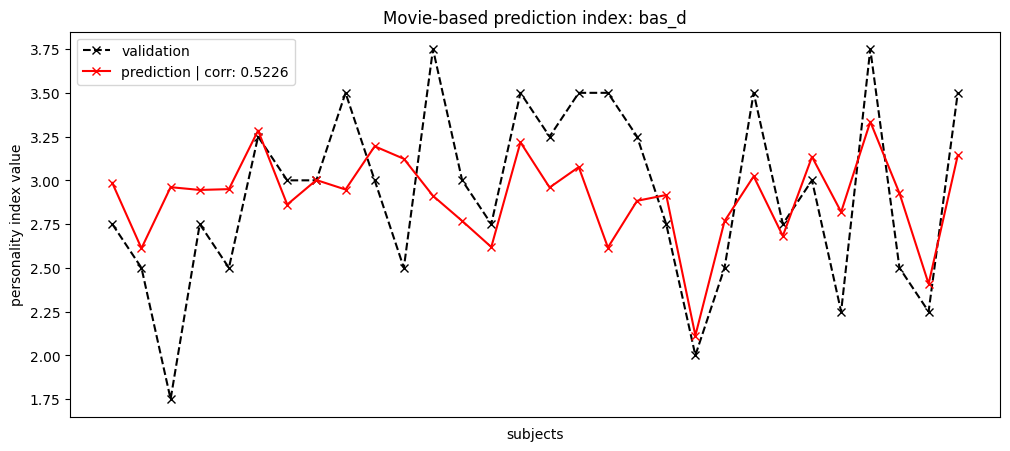

In [32]:
tmp1 = np.concatenate(np.asarray(BP_movie[5])[:,3])
tmp2 = np.concatenate(np.asarray(BP_movie[5])[:,2])
tmp3 = np.concatenate(np.asarray(null_BP_movie[11])[:,3])
tmp4 = np.concatenate(np.asarray(null_BP_movie[11])[:,2])

tmpcorr1 = pearson_correlation(tmp1,tmp2)
tmpcorr2 = pearson_correlation(tmp3,tmp4)

fig = plt.figure(figsize=(12,5))
ax  = fig.add_subplot(111)

plt.title('Movie-based prediction index: {}'.format(feat))

plt.plot(tmp1[np.argsort(tmp1)[order_fixed]], '--x', label='validation', c='k')
plt.plot(tmp2[np.argsort(tmp1)[order_fixed]], '-x', label='prediction | corr: {}'.format(round(tmpcorr1,4)), c='r')
# plt.plot(tmp3, '--x', label='validation 2', c='g')
# plt.plot(tmp4, '--x', label='prediction null | corr: {}'.format(round(tmpcorr2,4)))
plt.legend()

ax.set_xticklabels([])
ax.set_xticks([])

ax.set_xlabel('subjects')
ax.set_ylabel('personality index value')

Rest based prediction

In [11]:
np.random.seed(93)
kfold         = 3
lbd, rbd      = -5, 1
lambdas_lasso = np.logspace(lbd,rbd,50)
A             = gradients_rest.reshape(30,-1)

feat      = existing_psy[4]
psyscore  = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
psyscore  = np.array(psyscore)

# initial statistic
BP_rest = []
for i in tqdm(range(100)):
    results = combination_predict(Lasso, lambdas_lasso, A, psyscore, kfold=kfold, metric='R2', rd_state=i)
    BP_rest.append(results)
    
# null statistic    
null_BP_rest = []
for i in tqdm(range(100)):
    psyscore  = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore  = np.array(psyscore)
    np.random.shuffle(psyscore)
    results   = combination_predict(Lasso, lambdas_lasso, A, psyscore, kfold=kfold, metric='R2', rd_state=i)
    null_BP_rest.append(results)    

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
print("Good R^2 fit on all folds repeats {}".format(np.where((np.asarray(BP_rest)[:,:,0] > 0).sum(axis=1)==3)[0]))
print("Good R^2 fit on all folds repeats {}".format(np.where((np.asarray(null_BP_rest)[:,:,0] > 0).sum(axis=1)==3)[0]))

Good R^2 fit on all folds repeats [ 5  7 18 19 23 35 41 50 69 86 87]
Good R^2 fit on all folds repeats [ 5 31 56 61 62 65]


Text(0, 0.5, 'personality index value')

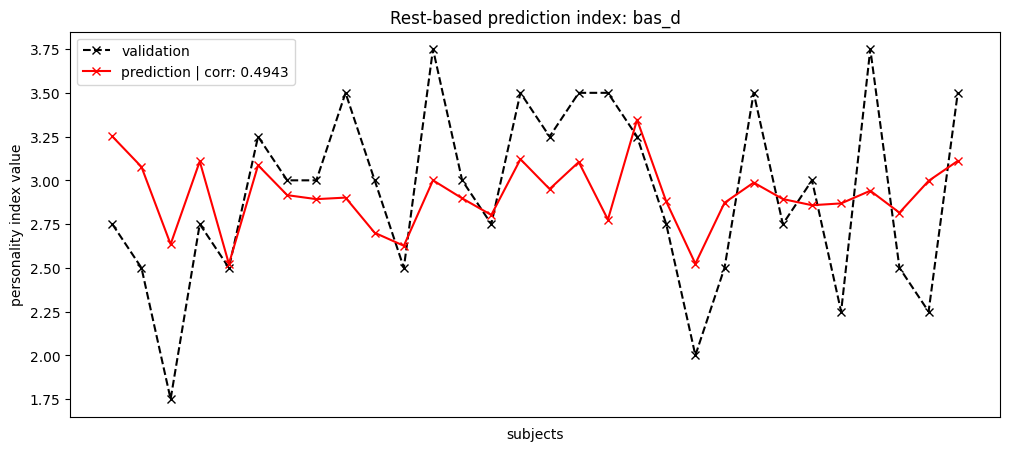

In [31]:
tmp1 = np.concatenate(np.asarray(BP_rest[87])[:,3])
tmp2 = np.concatenate(np.asarray(BP_rest[87])[:,2])
tmp3 = np.concatenate(np.asarray(null_BP_rest[78])[:,3])
tmp4 = np.concatenate(np.asarray(null_BP_rest[78])[:,2])


tmpcorr1 = pearson_correlation(tmp1,tmp2)
tmpcorr2 = pearson_correlation(tmp3,tmp4)

fig = plt.figure(figsize=(12,5))
ax  = fig.add_subplot(111)

plt.title('Rest-based prediction index: {}'.format(feat))

plt.plot(tmp1[np.argsort(tmp1)[order_fixed]], '--x', label='validation', c='k')
plt.plot(tmp2[np.argsort(tmp1)[order_fixed]], '-x', label='prediction | corr: {}'.format(round(tmpcorr1,4)), c='r')
# plt.plot(tmp3, '--x', label='prediction null | corr: {}'.format(round(tmpcorr2,4)))
plt.legend()

ax.set_xticklabels([])
ax.set_xticks([])

ax.set_xlabel('subjects')
ax.set_ylabel('personality index value')

#### Lasso on Full gradients (3 gradients) with k-fold

##### With Movie

In [33]:
lbd,rbd = -5,1
lambdas_lasso = np.logspace(lbd,rbd,20)

In [36]:
np.random.seed(10)

logs_movie     = {existing_psy[i]: [] for i in range(len(existing_psy))}
logsnull_movie = {existing_psy[i]: [] for i in range(len(existing_psy))}
A        = gradients_movie.reshape(30,-1)

for i in tqdm(range(len(existing_psy))):
    feat     = existing_psy[i]
    psyscore = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore = np.array(psyscore)
    psyscore = zscore(psyscore)

    corr_coef   = sample_solution(Lasso, lambdas_lasso, A, psyscore, 2, 200, metric='R2', rd_state=i)
    best_res    = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,2]))
    
    logs_movie[feat]  = best_res, best_coeffs, best_corrs

    corr_coef   = sample_solution(Lasso, lambdas_lasso, A, psyscore, 2, 200, null=True, metric='R2', rd_state=i)

    best_res    = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,2]))
    
    logsnull_movie[feat] = best_res, best_coeffs, best_corrs

  0%|          | 0/15 [00:00<?, ?it/s]

In [38]:
row = ['cov_total', 'DASS_dep', 'DASS_anx', 'DASS_str', 'bas_d', 'bas_f', 'bas_r', 
        'bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope', 'erq_cr', 'erq_es']

pred_distrib = {'pidx': [], 'foldcorr': []}
null_distrib = {'pidx': [], 'foldcorr': []}

for r in row:
    folds = logs_movie[r][2]
    folds = np.apply_along_axis(lambda x: (x > 0) * x, 0, folds)
    folds[folds == 0] = np.nan
    folds = np.nan_to_num(folds)
    
    foldsN = logsnull_movie[r][2]
    foldsN = np.apply_along_axis(lambda x: (x > 0) * x, 0, foldsN)
    foldsN[foldsN == 0] = np.nan
    foldsN = np.nan_to_num(foldsN)
    
    pred_distrib['foldcorr'] += list(folds)
    pred_distrib['pidx']     += len(folds) * [r]
    null_distrib['foldcorr'] += list(foldsN)
    null_distrib['pidx']     += len(foldsN) * [r]

pred_distrib  = pd.DataFrame.from_dict(pred_distrib)
null_distrib  = pd.DataFrame.from_dict(null_distrib)

In [39]:
pred_distrib['null'] = 0
null_distrib['null'] = 1

##### With Rest

In [41]:
lbd,rbd = -5,1
lambdas_lasso = np.logspace(lbd,rbd,20)

In [42]:
np.random.seed(10)

logs_rest     = {existing_psy[i]: [] for i in range(len(existing_psy))}
logsnull_rest = {existing_psy[i]: [] for i in range(len(existing_psy))}
A        = gradients_rest.reshape(30,-1)

for i in tqdm(range(len(existing_psy))):
    feat     = existing_psy[i]
    psyscore = [behavioural[behavioural.ID == subjects_order[s]][feat].item() for s in range(len(subjects_order))]
    psyscore = np.array(psyscore)
    psyscore = zscore(psyscore)

    corr_coef   = sample_solution(Lasso, lambdas_lasso, A, psyscore, 2, 200, metric='R2', rd_state=i)
    best_res    = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,2]))
    
    logs_rest[feat]  = best_res, best_coeffs, best_corrs

    corr_coef   = sample_solution(Lasso, lambdas_lasso, A, psyscore, 2, 200, null=True, metric='R2', rd_state=i)

    best_res    = np.asarray(list(np.asarray(corr_coef)[:,0]))
    best_coeffs = np.asarray(list(np.asarray(corr_coef)[:,1]))
    best_corrs  = np.asarray(list(np.asarray(corr_coef)[:,2]))
    
    logsnull_rest[feat] = best_res, best_coeffs, best_corrs

  0%|          | 0/15 [00:00<?, ?it/s]

In [43]:
row = ['cov_total', 'DASS_dep', 'DASS_anx', 'DASS_str', 'bas_d', 'bas_f', 'bas_r', 
        'bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope', 'erq_cr', 'erq_es']

pred_distrib = {'pidx': [], 'foldcorr': []}
null_distrib = {'pidx': [], 'foldcorr': []}

for r in row:
    folds = logs_rest[r][0]
    folds = np.apply_along_axis(lambda x: (x > 0) * x, 0, folds)
    folds[folds == 0] = np.nan
    folds = np.nan_to_num(folds)
    
    foldsN = logsnull_rest[r][0]
    foldsN = np.apply_along_axis(lambda x: (x > 0) * x, 0, foldsN)
    foldsN[foldsN == 0] = np.nan
    foldsN = np.nan_to_num(foldsN)
    
    pred_distrib['foldcorr'] += list(folds)
    pred_distrib['pidx'] += len(folds) * [r]
    null_distrib['foldcorr'] += list(foldsN)
    null_distrib['pidx'] += len(foldsN) * [r]

pred_distrib  = pd.DataFrame.from_dict(pred_distrib)
null_distrib  = pd.DataFrame.from_dict(null_distrib)

In [44]:
pred_distrib['null'] = 0
null_distrib['null'] = 1